In [10]:
import torch
from torch.nn import Linear
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

CLASSES = ["0", "1", "2", "3", "4"]

device = "cuda" if (torch.cuda.is_available()) else "cpu"
checkpoint = torch.load("./checkpoint-model")

model = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT)
model.fc = Linear(model.fc.in_features, len(CLASSES))
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [11]:
from torchvision.datasets.folder import pil_loader
from torch.nn.functional import softmax
from torchvision.transforms import Resize, CenterCrop, ToTensor, Compose, Normalize


kl_level = [
    "Not arthrosis [KL = 0]",
    "Not arthrosis [KL = 1]",
    "Arthrosis [KL = 2]",
    "Arthrosis [KL = 3]",
    "Arthrosis [KL = 4]"
]

def transform_image(image_path: str):
    my_transforms = Compose([
        Resize(255),
        CenterCrop(224),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = pil_loader(image_path)
    return my_transforms(img).unsqueeze(0)


def get_prediction(image_path: str):
    tensor = transform_image(image_path)
    tensor = tensor.to(device)
    output = model.forward(tensor)

    probs = softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    return conf.item(), kl_level[classes.item()]

Arthrosis [KL = 3] at confidence score: 0.98


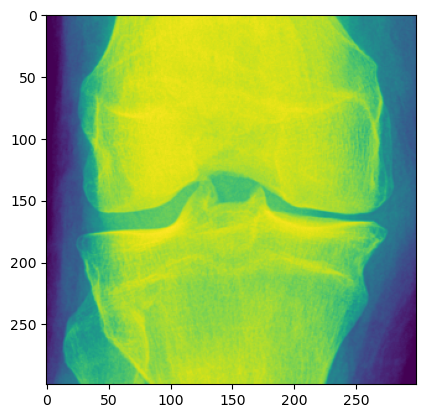

In [15]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from matplotlib import pyplot as plt

root = Tk()
image_path = askopenfilename(title="Pick an knee image",
                             filetypes=[("Images", "*.jpeg"), ("Images", "*.jpg"), ("Images", "*.png")])
root.destroy()

image = plt.imread(image_path)
plt.imshow(image)

conf, y_pre = get_prediction(image_path)
print(y_pre, "at confidence score: {0:.2f}".format(conf))